In [168]:
from cfl.experiment import Experiment
import numpy as np
import pandas as pd
from cfl.visualization.basic_visualizations import visualize_macrostates
from sklearn.preprocessing import StandardScaler

In [169]:
file = 'data/10km_data.csv'

data = pd.read_csv(file)
Xraw = np.array(data[['lat', 'long']])
Yraw = np.array(data['generated_temp']).reshape(-1,1)
print(Xraw.shape, Yraw.shape)

(12700, 2) (12700, 1)


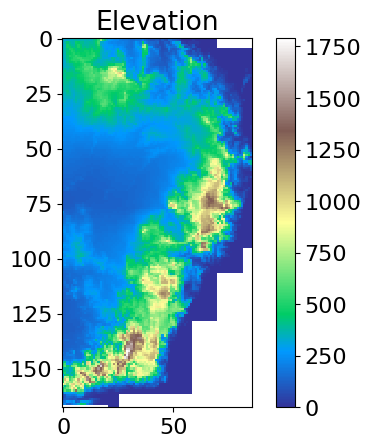

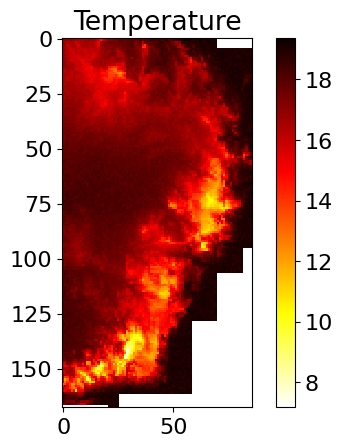

In [170]:
# PLOT TEMP AND ELEVATION FOR RAW DATAFRAME

import matplotlib.pyplot as plt

asc_longs = np.sort(data['long'].unique())
desc_lats = np.sort(data['lat'].unique())[::-1]

temp_grid = []
alt_grid = []

for lat in desc_lats:
    temp_row = []
    alt_row = []
    for long in asc_longs:
        point = data.loc[(data['lat'] == lat) & (data['long'] == long)]
        if len(point) == 0:
            temp_row.append(np.nan)
            alt_row.append(np.nan)
            continue
        temp_row.append(point['generated_temp'].values[0])
        alt_row.append(point['elevation'].values[0])
    temp_grid.append(temp_row)
    alt_grid.append(alt_row)

plt.figure(1)
plt.imshow(alt_grid, cmap='terrain', interpolation='nearest')
plt.colorbar()
plt.title('Elevation')
plt.show()

plt.figure(2)
plt.imshow(temp_grid, cmap='hot_r', interpolation='nearest')
plt.colorbar()
plt.title('Temperature')
plt.show()

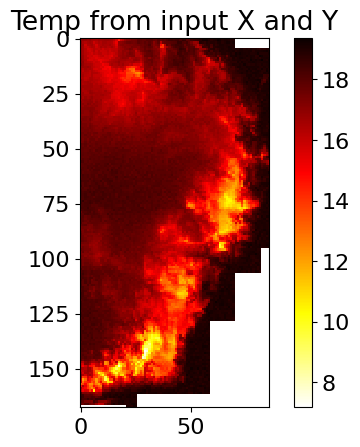

In [171]:
# PLOT TEMP USING X AND Y TO CHECK

unique_lats = np.unique(Xraw[:, 0])
unique_longs = np.unique(Xraw[:, 1])

asc_longs_pairs = sorted(zip(Xraw, Yraw), key=lambda p: p[0][1])
desc_lats_pairs = sorted(asc_longs_pairs, key=lambda p: p[0][0], reverse=True)

def get_zip_match(pairs, lat, long):
    for pair in pairs:
       coord = pair[0]
       if coord[0] == lat and coord[1] == long:
           return pair 
    return None

grid = []

for lat in desc_lats:
    row = []
    for long in asc_longs:
        pair = get_zip_match(desc_lats_pairs, lat, long)
        if pair == None:
            row.append(np.nan)
            continue
        row.append(pair[1][0])
    grid.append(row)

plt.imshow(grid, cmap='hot_r', interpolation='nearest')
plt.colorbar()
plt.title("Temp from input X and Y")
plt.show()

In [172]:
X = StandardScaler().fit_transform(Xraw)
Y = StandardScaler().fit_transform(Yraw)

In [173]:
# Create 3 dictionaries: one for data info, one with CDE parameters, and one with cluster parameters

# the parameters should be passed in dictionary form
data_info = {'X_dims' : X.shape,
             'Y_dims' : Y.shape,
             'Y_type' : 'continuous' #options: 'categorical' or 'continuous'
            }

# pass in empty parameter dictionaries to use the default parameter values (not
# allowed for data_info)
CDE_params = {  'model'        : 'CondExpMod',
                'model_params' : {
                    # model architecture
                    'dense_units' : [100, data_info['Y_dims'][1]],
                    'activations' : ['relu', 'linear'],
                    'dropouts'    : [0, 0],
                    # training parameters
                    'batch_size'  : 64,
                    'n_epochs'    : 2000,
                    'optimizer'   : 'adam',
                    'opt_config'  : {'lr' : 1e-4},
                    'loss'        : 'mean_squared_error',
                    'best'        : True,
                    'early_stopping' : True,
                    # verbosity
                    'verbose'     : 1,
                    'show_plot'   : True,
                }
}

# cluster_params consists of specifying two clustering objects
# CFL automatically recognizes the names of all sklearn.cluster models as keywords
cause_cluster_params =  {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : 100},
                         'verbose' : 0
}
effect_cluster_params = {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : 100},
                         'verbose' : 0
}

In [174]:
# block_names indicates which CDE and clustering models to use
block_names = ['CondDensityEstimator', 'CauseClusterer', 'EffectClusterer']

# block_params is aligned to block_names
block_params = [CDE_params, cause_cluster_params, effect_cluster_params]

results_path = 'sample_run' # directory to save results to

# Create a new CFL experiment with specified parameters
my_exp = Experiment(X_train=X,
                    Y_train=Y,
                    data_info=data_info,
                    block_names=block_names,
                    block_params=block_params,
                    results_path=results_path)

All results from this run will be saved to sample_run/experiment0013
Block: verbose not specified in input, defaulting to 1
CondExpBase: activity_regularizers not specified in input, defaulting to None
CondExpBase: kernel_regularizers not specified in input, defaulting to None
CondExpBase: bias_regularizers not specified in input, defaulting to None
CondExpBase: kernel_initializers not specified in input, defaulting to None
CondExpBase: bias_initializers not specified in input, defaulting to None
CondExpBase: weights_path not specified in input, defaulting to None
CondExpBase: tb_path not specified in input, defaulting to None
CondExpBase: optuna_callback not specified in input, defaulting to None
CondExpBase: optuna_trial not specified in input, defaulting to None
CondExpBase: checkpoint_name not specified in input, defaulting to tmp_checkpoints


#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
No GPU device detected.
Epoch 1/2000
149/149 [==============================] - 1s 2ms/step - loss: 1.1264 - val_loss: 1.0717
Epoch 2/2000
149/149 [==============================] - 0s 1ms/step - loss: 1.0059 - val_loss: 1.0013
Epoch 3/2000
149/149 [==============================] - 0s 2ms/step - loss: 0.9550 - val_loss: 0.9695
Epoch 4/2000
149/149 [==============================] - 0s 2ms/step - loss: 0.9275 - val_loss: 0.9488
Epoch 5/2000
149/149 [==============================] - 0s 1ms/step - loss: 0.9078 - val_loss: 0.9321
Epoch 6/2000
149/149 [==============================] - 0s 1ms/step - loss: 0.8915 - val_loss: 0.9171
Epoch 7/2000
149/149 [==============================] - 0s 1ms/step - loss: 0.8766 - val_loss: 0.9034
Epoch 8/2000
149/149 [==============================] - 0s 2ms/step - loss: 0.8629 - val_loss: 0.8903
Epoch 9/2000
149/149 [==================

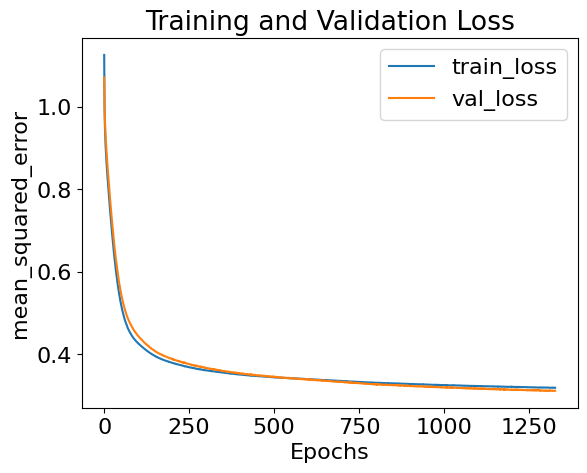

397/397 [==============================] - 0s 692us/step
Loading parameters from  tmp_checkpoints02012025235714/best_weights
Saving parameters to  sample_run/experiment0013/trained_blocks/CondDensityEstimator
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Beginning EffectClusterer training...


100%|██████████| 12700/12700 [00:17<00:00, 741.16it/s]


EffectClusterer training complete.
Experiment training complete.


In [175]:
results = my_exp.train()

# Reconstruct the elevation map based on labels

# LOOK IN DATA, POINTS ARE GROUPED BY LAT

# does ylbls even matter?

In [176]:
xlbls = results['CauseClusterer']['x_lbls']
ylbls = results['EffectClusterer']['y_lbls']

print(xlbls[:10], xlbls[-5:])
print(ylbls[:10], ylbls[-5:])

[71 37 37 97 97 79 60 28  0 62] [53 33 33 33  3]
[56 14 88 37 99 10 43  6 94 64] [45  3 37 56 72]


In [177]:
import matplotlib.pyplot as plt

df_copy = data[['lat', 'long']].copy()

def get_group_avgs(xlbls):
    elevations = list(data['elevation'])
    xlbl_avgs = {xlbl:[] for xlbl in xlbls}

    for i, xlbl in enumerate(xlbls):
        xlbl_avgs[xlbl].append(elevations[i])
    for key, arr in zip(xlbl_avgs.keys(), xlbl_avgs.values()):
        xlbl_avgs[key] = sum(arr)/len(arr)

    return xlbl_avgs

def plot_groups(xlbls, title='Reconstructed Terrain'):
    df_copy['xlbl'] = xlbls
    group_avgs = get_group_avgs(xlbls)

    asc_longs = np.sort(df_copy['long'].unique())
    desc_lats = np.sort(df_copy['lat'].unique())[::-1]
    
    grid = []
    points_count = 0

    for lat in desc_lats:
        row = []
        for long in asc_longs:
            point = df_copy[(df_copy['lat'] == lat) & (df_copy['long'] == long)]
            if point.empty:
                row.append(np.nan)
                continue
            
            group = point['xlbl'].values[0]
            row.append(group_avgs[group])
            points_count += 1
        
        grid.append(row)
    
    print(points_count)
    
    plt.imshow(grid, cmap='terrain', interpolation='nearest', vmin=0, vmax=data['elevation'].max())
    plt.colorbar()
    plt.title(title)
    plt.show()

12700


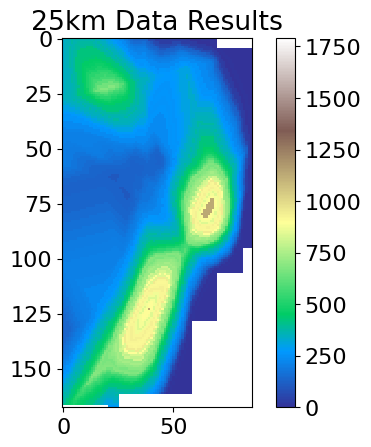

In [178]:
# xlbls = results['CauseClusterer']['x_lbls']
# ylbls = results['EffectClusterer']['y_lbls']

'''elevations = list(data['elevation'])
ylbl_avgs = {ylbl:[] for ylbl in set(ylbls)}

for i, ylbl in enumerate(ylbls):
    ylbl_avgs[ylbl].append(elevations[i])

for key, arr in zip(ylbl_avgs.keys(), ylbl_avgs.values()):
    ylbl_avgs[key] = sum(arr)/len(arr)

print(ylbl_avgs)'''

plot_groups(xlbls, title='25km Data Results')

# for 25km, used 50 clusters, for 10km, used 100 clusters